In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.neural_network import MLPRegressor

In [39]:
# Функция для оценки модели через построение графиков
def check_model(model=None, name="Model", day=1):
    # iloc конвертирует в список, потому что нельзя передать DF
    prediction = model.predict([X_test.iloc[day-1]])[0]
    real = Y_test.iloc[day-1]  
    mae = mean_absolute_error(prediction, real)
    print(f"For {name} on {day} day mean abs. error = {mae}")
    # Построение двух графиков на одной оси
    plt.plot(prediction, label="Предсказание")
    plt.plot(real, label="Реальные данные")
    plt.legend()
    plt.show()

In [6]:
# Подготовка данных для их загрузки в модель
# Курс доллара за 01.01.2018 - 01.07.2020
usd_rates = pd.read_excel("usd_rates.xlsx")

future = 7  # Предсказание на "future" дней
past = 4 * 7  # Предсказание на основе "past" дней
money = usd_rates.curs
start = past  # День, когда мы начинаем собирать данные для обучения
end = money.size - future  # День, когда заканчиваем

training_past = []
training_future = []
for day in range(start, end):
    past_data = money[(day-past):day]
    future_data = money[day:(day+future)]
    training_past.append(list(past_data))
    training_future.append(list(future_data))

# Генерация имён для столбцов DataFrame
future_columns = []
for i in range(future):
    future_columns.append(f"future_{i}")
past_columns = []
for i in range(past):
    past_columns.append(f"past_{i}")

past_df = pd.DataFrame(training_past, columns=past_columns)
future_df = pd.DataFrame(training_future, columns=future_columns)  

# Учебник - training set
X_train = past_df[:-10]
Y_train = future_df[:-10]
# Экзамен - test set
X_test = past_df[-10:]
Y_test = future_df[-10:]

In [7]:
from sklearn.neural_network import MLPRegressor

In [8]:
mlp = MLPRegressor()
mlp.fit(X_train, Y_train)

D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(100,), learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=200,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=None, shuffle=True, solver='adam',
             tol=0.0001, validation_fraction=0.1, verbose=False,
             warm_start=False)

For MLPRegressor on 1 day mean abs. error = 1.4294634750965198


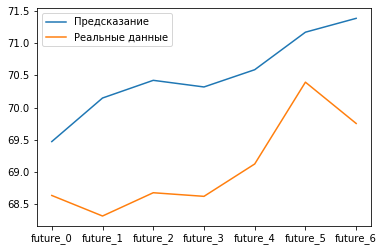

In [40]:
check_model(mlp, "MLPRegressor")

In [14]:
# GridSearchCV позволяет подобрать удачные значения параметров модели
# Grid Search - поиск по сетке параметров
#
# например, хотим перебрать следующие варианты параметров 
# max_iter = 100, 500, 1000, 2000
# learning_rate_init = 0.001, 1, 0.1, 0.01
#
# CV - cross validation
# обучить модель несколько раз на разных разбиениях выборки
#
# * - обучающие, Х - тестовые
# [****************XXXXXXXX] - 30% тестов
#
# CV - перемешать выборку и обучить модель несколько раз на разных разбиениях выборки
# [XXXX*****************]
# [****XXXX*************]
# [********XXXX*********]
# [*************XXXX****]
# [*****************XXXX]

In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor

In [16]:
KNR = KNeighborsRegressor(p=2)

In [18]:
# Та самая сетка параметров
param_grid = {
    "n_neighbors": [1, 2, 4, 8],
    "weights": ['uniform', 'distance']
}

In [33]:
# В GridSearchCV передаётся модель, сетка параметров, критерий качества (функция ошибки) и количество CV (разбиений)
gs = GridSearchCV(KNR, param_grid, "neg_mean_absolute_error", cv=4)

In [34]:
gs.fit(X_train, Y_train)

GridSearchCV(cv=4, error_score=nan,
             estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30,
                                           metric='minkowski',
                                           metric_params=None, n_jobs=None,
                                           n_neighbors=5, p=2,
                                           weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': [1, 2, 4, 8],
                         'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_absolute_error', verbose=0)

In [23]:
gs.best_score_  # лучшая ошибка
gs.best_params_  # лучшая последовательность параметров
best_model = gs.best_estimator_  # лучшая модель

In [29]:
KNR_model = KNeighborsRegressor(p=2)
KNR_model.fit(X_train, Y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')

For KNeighborsRegressor without GridSearchCV on 4 day mean abs. error = 0.8784800000000043


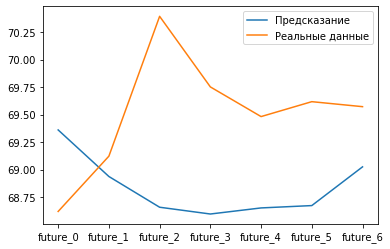

For KNeighborsRegressor with GridSearchCV on 4 day mean abs. error = 0.8567964285714282


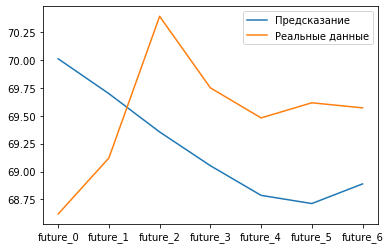

In [41]:
check_model(KNR_model, "KNeighborsRegressor without GridSearchCV", 4)
check_model(best_model, "KNeighborsRegressor with GridSearchCV", 4)